<a href="https://colab.research.google.com/github/zecakpm/NLP-product_reviews/blob/main/reviews_amzn_log_reg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Here my approach:
* select product with most reviews
* split the data set  (train and test)
* data engineering (remove adjectives from text and text into numbers)
* train the model (Logistic Regression)
* plot SHAP value

Conclusions:
- The work "love" is strongest word by our model to define a rate
- Product caracteristis 

Link for the exploratory notebook.
Here you can how the 

Reference material

https://medium.com/artefact-engineering-and-data-science/customer-reviews-use-nlp-to-gain-insights-from-your-data-4629519b518e

#**Install any necessary library**

In [3]:
!pip install shap

     |████████████████████████████████| 358kB 7.5MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491619 sha256=accc172159637d1c42489d266d12ce91e78b61ace8bb2b0930786f6f59c86d17
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


# **Import Libraries**

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import shap
import seaborn as sns

#**Connecting with Google Drive**

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**Open file from Google Drive**

In [6]:
#open file
df_lem = open('/content/drive/My Drive/Colab Notebooks/NLP/eda_amzn/df_lema.csv')

#**Convert file to a DataFrame**

In [7]:
#csv to a dataframe
df_lem = pd.read_csv(df_lem)

#**Selecting product with most reviews**
 - create 2 copys, this will be helpful to run the model twice later on

In [8]:
df_test = df_lem[df_lem['name'] == 'Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offers, Magenta'].copy()
df_test = df_test.reset_index()
df_test['lemmatized'].values.astype('str')

array(['sale people nice knowledgeable come',
       'great product service sale man r nice',
       'great product service refer friend sale man r good', ...,
       'buy birthday gift son like ise android system like figure price ok',
       'great kid adult great product game reading',
       'kid break tablet want specifically kid amazon fire 7 fit need happy purchase'],
      dtype='<U1572')

In [9]:
df = df_lem[df_lem['name'] == 'Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offers, Magenta'].copy()
df = df.reset_index()
df['lemmatized'].values.astype('str')

array(['sale people nice knowledgeable come',
       'great product service sale man r nice',
       'great product service refer friend sale man r good', ...,
       'buy birthday gift son like ise android system like figure price ok',
       'great kid adult great product game reading',
       'kid break tablet want specifically kid amazon fire 7 fit need happy purchase'],
      dtype='<U1572')

In [ ]:
df.head()

#**Create new column with review length + plot distribution**

In [10]:
df['text_len'] = [len(i) for i in df['reviews.text']]

Text(0.5, 6.79999999999999, 'text length')

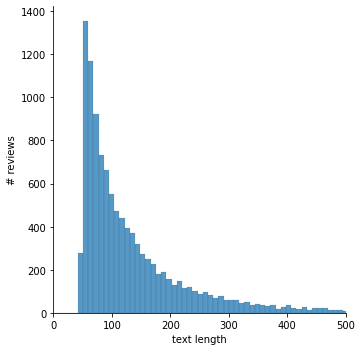

In [11]:
sns.displot(df['text_len'])
plt.xlim([0,500]);
plt.ylabel('# reviews')
plt.xlabel('text length')

#**Generating Bigrams**
* Bigram is a lean format to understand word meaning within a context (i.e. the book, book a room)

In [12]:
from collections import Counter
from itertools import chain

In [ ]:
def find_ngrams(column,n):
  return list(zip(*[column[i:] for i in range(n)]))

df['bigrams'] = df['lemmatized'].map(lambda x: find_ngrams(str(x).split(" "),2))
df.head()

In [14]:
bigrams = df['bigrams'].tolist()
bigrams = list(chain(*bigrams))
bigrams = [(x.lower(), y.lower()) for x, y in bigrams]

bigram_counts = Counter(bigrams)
bigram_counts.most_common(20)

[(('easy', 'use'), 901),
 (('year', 'old'), 626),
 (('great', 'tablet'), 593),
 (('kindle', 'fire'), 481),
 (('great', 'price'), 475),
 (('play', 'game'), 454),
 (('read', 'book'), 372),
 (('work', 'great'), 369),
 (('tablet', 'great'), 339),
 (('good', 'tablet'), 336),
 (('amazon', 'fire'), 303),
 (('tablet', 'price'), 298),
 (('buy', 'tablet'), 290),
 (('black', 'friday'), 288),
 (('fire', 'tablet'), 276),
 (('good', 'buy'), 269),
 (('kid', 'love'), 262),
 (('love', 'tablet'), 255),
 (('great', 'product'), 234),
 (('battery', 'life'), 213)]

#**Selecting prediction and tagert variables**

In [15]:
X = df['lemmatized'].values.astype('U')
y = df['reviews.rating']

In [16]:
print("X type ===>", type(X))
print("y type ===>", type(y))
print("X size ===>", X.shape)
print("y size ===>", y.shape)

X type ===> <class 'numpy.ndarray'>
y type ===> <class 'pandas.core.series.Series'>
X size ===> (10962,)
y size ===> (10962,)


#**Spliting and vectorizing DataFrame**

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

vectorizer = TfidfVectorizer(min_df=10)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

print("X_train size ===>", X_train.shape)
print("y_train size ===>", y_train.shape)
print("X_test size ===>", X_test.shape)
print("y_test size ===>", y_test.shape)


X_train size ===> (8769, 929)
y_train size ===> (8769,)
X_test size ===> (2193, 929)
y_test size ===> (2193,)


#**Training Logistic Regression Model**

In [ ]:
%%time
model = sklearn.linear_model.LogisticRegression()
model.fit(X_train, y_train)

#**Calculating and plotting SHAP value**

In [19]:
explainer = shap.LinearExplainer(model, X_train)
shap_values = explainer.shap_values(X_test)
X_test_array = X_test.toarray() # we need to pass a dense version for the plotting functions

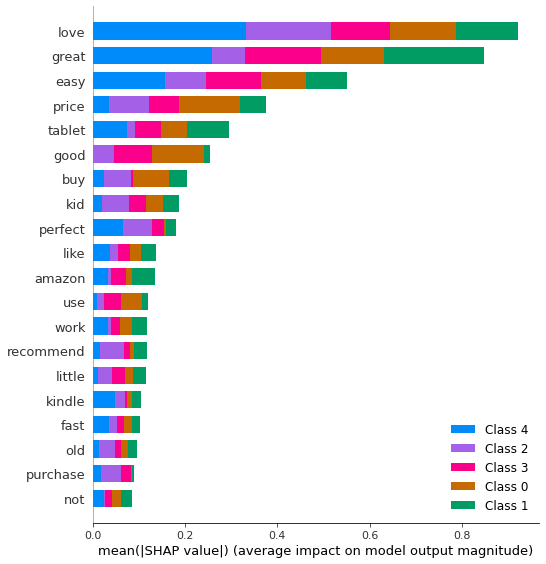

In [20]:
shap.summary_plot(shap_values, X_test_array, feature_names=vectorizer.get_feature_names())

#**Searching for product features**

* import nltk libraries
* create functions
* run functions on prediction column
* repeat steps from the first section

In [21]:
import nltk
from nltk import pos_tag, word_tokenize
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

#**Functions** 
* list of non adjectives
* convert list to string
* Apply functions to columns 

In [22]:
def col_tokenization(sent):
    list = []
    for word, pos in pos_tag(word_tokenize(sent)):
      if not pos.startswith('JJ'):
        list.append(word)
    return list

In [23]:
def listToSring(list):
  str1 = " "
  return (str1.join(list))

In [24]:
%%time
df_test['sent_tk']=df_test['lemmatized'].apply(lambda x: col_tokenization(str(x)))

CPU times: user 11.2 s, sys: 165 ms, total: 11.4 s
Wall time: 11.4 s


In [25]:
df_test['to_string']=df_test['sent_tk'].apply(lambda x: listToSring(x))

In [ ]:
df_test.head()

#**Selecting prediction and tagert variables**

In [27]:
X1 = df_test['to_string'].values.astype('U')
y1 = df_test['reviews.rating']

In [28]:
print("X1 type ===>", type(X))
print("y1 type ===>", type(y))
print("X1 size ===>", X.shape)
print("y1 size ===>", y.shape)

X1 type ===> <class 'numpy.ndarray'>
y1 type ===> <class 'pandas.core.series.Series'>
X1 size ===> (10962,)
y1 size ===> (10962,)


#**Spliting and vectorizing DataFrame**

In [29]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=7)

vectorizer = TfidfVectorizer(min_df=10)
X1_train = vectorizer.fit_transform(X1_train)
X1_test = vectorizer.transform(X1_test)

print("X1_train size ===>", X1_train.shape)
print("y1_train size ===>", y1_train.shape)
print("X1_test size ===>", X1_test.shape)
print("y1_test size ===>", y1_test.shape)


X1_train size ===> (8769, 741)
y1_train size ===> (8769,)
X1_test size ===> (2193, 741)
y1_test size ===> (2193,)


#**Training Logistic Regression Model**

In [ ]:
%%time
model1 = sklearn.linear_model.LogisticRegression()
model1.fit(X1_train, y1_train)

#**Calculating and plotting SHAP value**

In [31]:
explainer1 = shap.LinearExplainer(model1, X1_train)
shap_values1 = explainer1.shap_values(X1_test)
X_test_array1 = X1_test.toarray() # we need to pass a dense version for the plotting functions

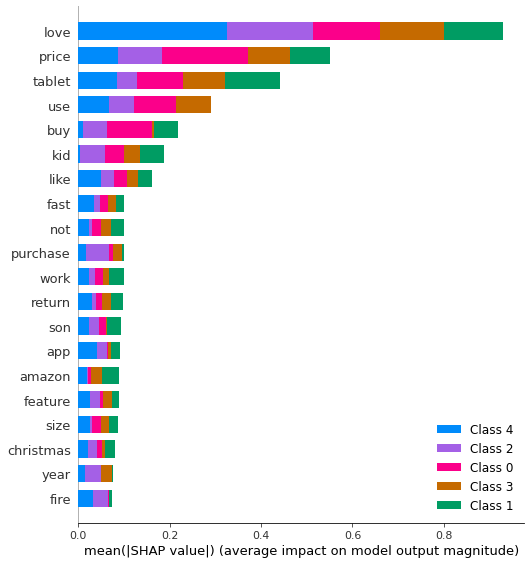

In [32]:
shap.summary_plot(shap_values1, X_test_array1, feature_names=vectorizer.get_feature_names())